In [2]:
from __future__ import print_function

import mxnet as mx

In [4]:
from mxnet import nd, autograd
from mxnet import gluon

import numpy as np

In [8]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()
# model_ctx = mx.gpu()

In [7]:
mx.gpu()

gpu(0)

In [9]:
batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)
train_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              batch_size, shuffle=False)

In [10]:
# define the multiclass logistic regression model
net = gluon.nn.Dense(num_outputs)

In [12]:
# Parameter initialization
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=model_ctx)

In [13]:
# Softmax Cross Entropy Loss
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [15]:
# Optimizer
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

In [16]:
# Evaluation Metric
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [19]:
# prior to training
evaluate_accuracy(test_data, net)

0.89090000000000003

In [18]:
# training
epochs = 10
moving_loss = 0.

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(model_ctx).reshape((-1,784))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = net(data) # forward
            loss = softmax_cross_entropy(output, label) # calculate loss
        loss.backward() # backward propagation
        trainer.step(batch_size) # update by SGD
        cumulative_loss += nd.sum(loss).asscalar()

    test_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    print("Epoch %s. Loss: %s, Train_acc %s, Test_acc %s" % (e, cumulative_loss/num_examples, train_accuracy, test_accuracy))

Epoch 0. Loss: 2.12915333066, Train_acc 0.79135, Test_acc 0.8055
Epoch 1. Loss: 0.909872276036, Train_acc 0.836766666667, Test_acc 0.8475
Epoch 2. Loss: 0.744189802583, Train_acc 0.853083333333, Test_acc 0.8636
Epoch 3. Loss: 0.657684579587, Train_acc 0.863766666667, Test_acc 0.8741
Epoch 4. Loss: 0.600498411798, Train_acc 0.8715, Test_acc 0.8788
Epoch 5. Loss: 0.560063743202, Train_acc 0.876916666667, Test_acc 0.8831
Epoch 6. Loss: 0.528706683342, Train_acc 0.88135, Test_acc 0.8863
Epoch 7. Loss: 0.503676245435, Train_acc 0.8846, Test_acc 0.8878
Epoch 8. Loss: 0.483230466342, Train_acc 0.8875, Test_acc 0.889
Epoch 9. Loss: 0.465413863762, Train_acc 0.888583333333, Test_acc 0.8909


In [20]:
# visualize predictions
import matplotlib.pyplot as plt

def model_predict(net,data):
    output = net(data.as_in_context(model_ctx))
    return nd.argmax(output, axis=1)

# let's sample 10 random data points from the test set
sample_data = mx.gluon.data.DataLoader(
    mx.gluon.data.vision.MNIST(train=False, transform=transform),
                              10, shuffle=True)

(10, 28, 28, 1)


model predictions are: 
[ 1.  8.  6.  0.  4.  4.  1.  5.  2.  5.]
<NDArray 10 @cpu(0)>


(10, 28, 28, 1)


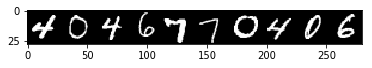

model predictions are: 
[ 4.  0.  4.  6.  7.  7.  0.  4.  0.  6.]
<NDArray 10 @cpu(0)>


In [21]:
for i, (data, label) in enumerate(sample_data):
    data = data.as_in_context(model_ctx)
    print(data.shape)
    im = nd.transpose(data,(1,0,2,3))
    im = nd.reshape(im,(28,10*28,1))
    imtiles = nd.tile(im, (1,1,3))

    plt.imshow(imtiles.asnumpy())
    plt.show()
    pred=model_predict(net,data.reshape((-1,784)))
    print('model predictions are:', pred)
    break